In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
np.random.seed(16082011)

 - http://www.users.on.net/~zygmunt.szpak/ellipsefitting.html
 - https://www.researchgate.net/publication/3659879_Direct_Least-squares_fitting_of_ellipses/link/00463531e42a2a932f000000/download
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
 - https://en.wikipedia.org/wiki/Rayleigh_quotient

In [3]:
def scale(a=2, b=1):
    return np.array([[a, 0], [0, b]])

In [4]:
def rotation(alpha=np.pi/4):
    return np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha),  np.cos(alpha)]
    ])

In [5]:
def circle(phi, rho=1):
    return rho*np.array([np.cos(phi), np.sin(phi)])

In [6]:
def ellipse(phi, rho, alpha, S, Xc):
    C = circle(phi, rho=rho)
    R = rotation(alpha)
    S = scale(*S)
    Xc = np.array(Xc)
    return np.dot(R, np.dot(S, C)).T + Xc

In [7]:
def params(A,B,C,D,E,F):
    return [
        -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2-4*A*C)*F)*((A+C)+np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C),
        -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2-4*A*C)*F)*((A+C)-np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C),
        (2*C*D-B*E)/(B**2-4*A*C),
        (2*A*E-B*D)/(B**2-4*A*C),
        np.arctan((C-A-np.sqrt((A-C)**2+B**2))/B)
    ]

In [8]:
def objective(x, a, b, c, d, e):
    return a*x[:,0]**2 + b*x[:,0]*x[:,1] + c*x[:,1]**2 + d*x[:,0] + e*x[:,1]

In [9]:
def u(x):
    return np.array([x[:,0]**2, x[:,0]*x[:,1], x[:,1]**2, x[:,0], x[:,1], np.ones_like(x[:,0])])

In [10]:
t = np.linspace(np.pi/2+0.25, 3/2*np.pi+0.25, 200)
t = np.linspace(0, np.pi, 200)
t = np.linspace(np.pi/2+0.25, 3/2*np.pi-0.25, 200)
t2 = np.linspace(0, 2*np.pi, 200)
e = np.random.randn(t.size)*1e-1

In [11]:
alpha = np.pi/4
S = [5, 3]
Xc = [2, 1]

In [12]:
X = ellipse(phi=t, rho=2+e, alpha=alpha, S=S, Xc=Xc)
Xr = ellipse(phi=t2, rho=2, alpha=alpha, S=S, Xc=Xc)

In [13]:
optsol, optcov = optimize.curve_fit(objective, X, np.ones_like(X[:,0]))
optsol

array([ 0.01265283, -0.02333137,  0.01249618, -0.10617916, -0.05892398])

In [14]:
r1 = np.array(params(*(list(optsol)+[-1])))
r1

array([72.34223397, 14.0054853 , 45.72813363, 45.04671226,  0.78875512])

In [15]:
Xhat1 = ellipse(phi=t2, rho=1, alpha=r1[4], S=r1[:2], Xc=r1[2:4])

In [16]:
Xb = u(X).T

In [17]:
M = np.dot(Xb.T, Xb)

In [18]:
M

array([[ 1.23029188e+05,  5.23923988e+04,  7.07515440e+04,
        -2.01441240e+04, -1.21794722e+04,  4.07495443e+03],
       [ 5.23923988e+04,  7.07515440e+04,  5.89740934e+04,
        -1.21794722e+04, -1.07292076e+04,  1.67454650e+03],
       [ 7.07515440e+04,  5.89740934e+04,  2.28418537e+05,
        -1.07292076e+04, -3.42622746e+04,  5.53170878e+03],
       [-2.01441240e+04, -1.21794722e+04, -1.07292076e+04,
         4.07495443e+03,  1.67454650e+03, -6.36136738e+02],
       [-1.21794722e+04, -1.07292076e+04, -3.42622746e+04,
         1.67454650e+03,  5.53170878e+03, -8.35677605e+02],
       [ 4.07495443e+03,  1.67454650e+03,  5.53170878e+03,
        -6.36136738e+02, -8.35677605e+02,  2.00000000e+02]])

In [19]:
l, U = np.linalg.eigh(M)

In [20]:
l

array([1.57359722e+00, 7.34761898e+01, 6.93550485e+02, 3.69964810e+04,
       9.69693050e+04, 2.97271546e+05])

In [21]:
U

array([[-0.01232297, -0.09172815, -0.10414135, -0.45449608, -0.75677873,
        -0.44867354],
       [ 0.02333713, -0.07434883, -0.04544264,  0.8838581 , -0.32205012,
        -0.32701861],
       [-0.01217124, -0.09880616,  0.10101336, -0.10615829,  0.54707261,
        -0.81812437],
       [ 0.10692905, -0.6149421 , -0.7644527 , -0.014303  ,  0.14204118,
         0.07512781],
       [ 0.06025765, -0.76521965,  0.62484501, -0.00994483, -0.06373871,
         0.1273385 ],
       [ 0.9920134 ,  0.11216345,  0.04546021, -0.02559529, -0.00655139,
        -0.02375106]])

In [22]:
U[:,0]

array([-0.01232297,  0.02333713, -0.01217124,  0.10692905,  0.06025765,
        0.9920134 ])

In [23]:
r2 = np.array(params(*U[:,0]))
r2

array([ 17.15029353, 110.29144838,  72.47026596,  71.95263102,
        -0.78214754])

In [24]:
Xhat2 = ellipse(phi=t2, rho=1, alpha=r2[4], S=r2[:2], Xc=r2[2:4])

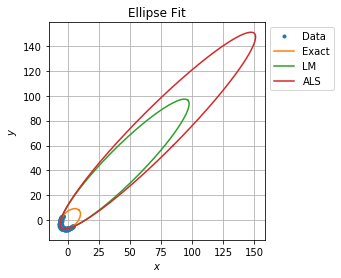

In [25]:
fig, axe = plt.subplots()
axe.plot(X[:,0], X[:,1], '.', label='Data')
axe.plot(Xr[:,0], Xr[:,1], label='Exact')
axe.plot(Xhat1[:,0], Xhat1[:,1], label='LM')
axe.plot(Xhat2[:,0], Xhat2[:,1], label='ALS')
axe.set_title('Ellipse Fit')
axe.set_xlabel('$x$')
axe.set_ylabel('$y$')
axe.set_aspect('equal', adjustable='box')
axe.legend(bbox_to_anchor=(1,1))
axe.grid()